In [47]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

from skimage.measure import ransac
from skimage.measure import structural_similarity as ssim
from skimage import io
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage.transform import warp
from skimage.feature import ORB
from skimage.feature import match_descriptors
from skimage.transform import ProjectiveTransform, AffineTransform, SimilarityTransform

from utils.transform import TranslationTransform
from utils.training import *
from utils.align import *
from utils.renderer import *
from utils.training import *

%matplotlib inline

This notebook serves these purposes:

  * Verifying whenever algo align JPG and TIF, alignment is reasonable.
  * Find out why certain TIF / JPG don't align (actual mismatches or algo deficiency)

In [48]:

#target_filename = 'train_2080'
#target_filename = 'train_2078' # primary fuzzy failed
#target_filename = 'train_10483'
#target_filename = 'train_10826' #failed
#target_filename = 'train_22564' # failed to find keypoints when it should
#target_filename = 'train_3449' # found keypoints that don't match
#target_filename = 'train_5461'  # failed to find keypoints due to blurriness


target_filename = 'train_196'

#target_filename = 'train_17173' #cloud
#target_filename = 'train_38296' # all matched points are super closed to each other producing scale factor of 0.75
#target_filename = 'train_18173'# exactly the same between TIF and JPG

jpg_filename = train_jpg(target_filename)
tiff_filename = train_tif(target_filename)

#target_filename = 'file_12753'
#target_filename = 'file_12756' # no keypoints
#jpg_filename = test_jpg(target_filename)
#tiff_filename = test_tif(target_filename)


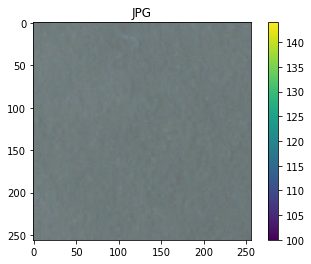

In [49]:
# train_17173 has JPG and TIF mis-aligned
show_jpg(jpg_filename)

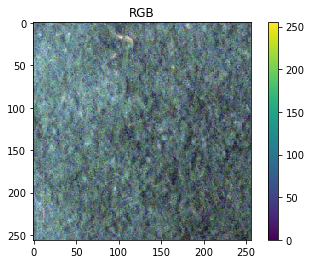

In [50]:
show_tiff_rgb(tiff_filename)

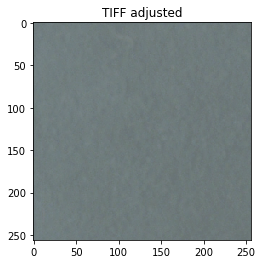

In [51]:
jpg_img_raw = cv2.imread(jpg_filename)
tif_img_raw = cv2.imread(tiff_filename, cv2.IMREAD_UNCHANGED)

im_tif_adjusted = match_color_curve_tif2jpg(tif_img_raw, jpg_img_raw)
plt.title('TIFF adjusted')
plt.imshow(im_tif_adjusted)


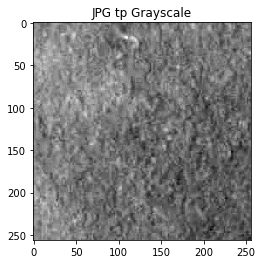

In [52]:
jpg_img_raw = cv2.imread(jpg_filename)

jpg_gray = cv2.cvtColor(jpg_img_raw,cv2.COLOR_BGR2GRAY).astype(np.uint8)
plt.title('JPG tp Grayscale')
plt.imshow(jpg_gray, cmap=plt.cm.gray)

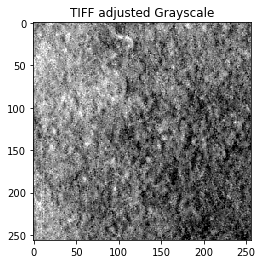

In [53]:
tif_gray = cv2.cvtColor(im_tif_adjusted,cv2.COLOR_BGR2GRAY).astype(np.uint8)
plt.title('TIFF adjusted Grayscale')
plt.imshow(tif_gray, cmap=plt.cm.gray)

In [54]:
number_of_keypoints = 100

# Initialize ORB
# This number of keypoints is large enough for robust results, 
# but low enough to run quickly. 
orb = ORB(n_keypoints=number_of_keypoints, fast_threshold=0.05)
# Detect keypoints
orb.detect_and_extract(jpg_gray)
keypoints_jpg = orb.keypoints
descriptors_jpg = orb.descriptors

orb2 = ORB(n_keypoints=number_of_keypoints, fast_threshold=0.05)
orb2.detect_and_extract(tif_gray)
keypoints_tif = orb2.keypoints
descriptors_tif = orb2.descriptors



IndexError: list index out of range

In [ ]:


# Match descriptors between images
matches = match_descriptors(descriptors_jpg, descriptors_tif, cross_check=True)

from skimage.feature import plot_matches
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, jpg_gray, tif_gray, keypoints_jpg, keypoints_tif, matches)

ax.axis('off');

To filter out the false matches, we apply RANdom SAmple Consensus (RANSAC), a powerful method of rejecting outliers available in skimage.transform.ransac. The transformation is estimated using an iterative process based on randomly chosen subsets, finally selecting the model which corresponds best with the majority of matches.

In [ ]:
# Select keypoints from
#   * source (image to be registered)
#   * target (reference image)
src = keypoints_jpg[matches[:, 0]][:, ::-1]
dst = keypoints_tif[matches[:, 1]][:, ::-1]

model_robust, inliers = ransac((src, dst), 
                                TranslationTransform,
                                min_samples=4, 
                                residual_threshold=1, 
                                max_trials=300)

#print (inliers)
print("number of matches", np.sum(inliers))
#print(inliers.shape[0])

if inliers is not None:
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    plot_matches(ax, jpg_gray, tif_gray, keypoints_jpg, keypoints_tif, matches[inliers])
    ax.axis('off');
else:
    print('no matching keypoint. image are definitely not correlated!')

In [ ]:
print(model_robust)
# scale is expected to be near 1.0 and rotation is expected to be very near 0.0.
print('translation', model_robust.translation)
print('rotation', model_robust.rotation)
print('scale', model_robust.scale)
#print(model_robust.shear)

In [ ]:
plt.imshow(tif_gray, cmap=plt.cm.gray)

In [ ]:
print(model_robust)

In [ ]:
warped_tiff = warp(tif_gray, model_robust)
plt.title('Warped TIFF Grayscale')
plt.imshow(warped_tiff, cmap=plt.cm.gray)
print(warped_tiff.shape)

In [ ]:
print(model_robust.params)
model_robust.params[0,0] = 1.0
model_robust.params[1,1] = 1.0
print(model_robust.params)

warped_tiff_full = warp(tif_img_raw, model_robust)
print(warped_tiff_full.shape)

In [ ]:
show_tiff_image_data(tif_img_raw)

In [ ]:
show_tiff_image_data(warped_tiff_full)

In [ ]:
print(warped_tiff_full.shape)

print(warped_tiff_full[0,0,:])
print(warped_tiff_full[125,125,:])